# Benchmark test against SLAC-GP and other toolboxes
Use only 2 dimensions, H1 and deltaH, use the CNN model trained in tensorflow that predicts emittance + defocus on the whole frame of Ronchigram.

The results from SLAC-GP and other toolboxes are generated from Bayesian-optimization-using-Gaussian-Process/Benchmark_optimizers.ipynb

In [1]:
# Import tensorflow for the CNN and limit the memory usage
import tensorflow as tf
import os

gpus = tf.config.experimental.list_physical_devices('GPU')
os.environ["CUDA_VISIBLE_DEVICES"]="1" # specify which GPU to use
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [2]:
# Load necessary libraries
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound
from botorch.models.transforms.outcome import Standardize

import time
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# Parameters setup
device = "cpu"  # for now, set device to CPU as the number of samples are small.
dtype = torch.double
NOISE_SE = 0.0
niter = 50
nrep = 1
option_standardize = True

In [4]:
# Function that loads the saved weights in CNN.

# input:
# path: hdf5 file that saves the weights of a VGG16 network.

# output:
# model: Keras model with VGG16 architecture and the loaded weights.
from keras import applications
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense

def loadCNNmodel(path):
    model = applications.VGG16(weights=None, include_top=False, input_shape=(128, 128, 3))
    print('Model loaded')
    top_model = Sequential()
    top_model.add(Flatten(input_shape=model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.0))
    top_model.add(Dense(1,activation=None))
    new_model = Sequential()

    for l in model.layers:
        new_model.add(l)

    new_model.add(top_model)
    new_model.load_weights(path)
    print('CNN model loaded with weights.')
    return new_model

Using TensorFlow backend.


In [42]:
# model using the whole FOV
# model_path = '/home/chenyu/Desktop/CNNmeasurement/CoarseCNNtraining/VGG16/OptimalPar_newData/Test6_Normalize_HighCs_emitxdefocus/Attempt_10_emit+defocus_Adam/Final_model_2.h5'
model_path = '/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/CNNmodels/VGG16_emit+defocus_test6_attempt3.h5'
model = loadCNNmodel(model_path)

Model loaded
CNN model loaded with weights.


In [43]:
def scale_range(input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

In [44]:
def aperture_generator(px_size, simdim, ap_size):
    x = np.linspace(-simdim, simdim, px_size)
    y = np.linspace(-simdim, simdim, px_size)
    xv, yv = np.meshgrid(x, y)
    apt_mask = mask = np.sqrt(xv*xv + yv*yv) < ap_size # aperture mask
    return apt_mask

In [45]:
# the function to get the output from GPT
# input:
# x: coordinate in the parameter space to be observed, 1-by-6 numpy array with each number between [0,1].
# model: Keras model that saves the CNN model to quantify the beam quality from GPT output.

# output:
# y: single number from CNN output, higher stands for better beam quality.
import sys
sys.path.insert(1, '/home/chenyu/Desktop/git/STEMalign/GPTrelated/')
from uscope_calc import sim

def get_GPT_output(x, model, aperture):
    x_list = []
    x_low = np.asarray([1000, -40, 387000, -685000, -3.7515e6, 119000, 640000])
    x_high = np.asarray([2800, 40, 393000, -622500, -3.7495e6, 120300, 651000])
    xlim, ylim, shadow = sim(
        alpha = 1.0e-4*5,
        H1 = x[0] * (x_high[0] - x_low[0]) + x_low[0],
        H2 = x[0] * (x_high[0] - x_low[0]) + x_low[0] + x[1] * (x_high[1] - x_low[1]) + x_low[1],
        S1 = 2.5e5,
        S2 = 2.5e5,
        S3 = 119931.5,
        S4 = 648691.415,
        S6 = 390000,
        S7 = -654100.0,
        Obj = -3.7505e6,
    )
    frame = scale_range(shadow, 0, 1)
    new_channel = np.zeros(frame.shape)
    img_stack = np.dstack((frame, new_channel, new_channel))
    x_list.append(img_stack)
    x_list = np.concatenate([arr[np.newaxis] for arr in x_list])
    prediction = model.predict(x_list, batch_size = 1)
    # print(prediction)
    return shadow, 1 - prediction[0][0]

0.786025881767273


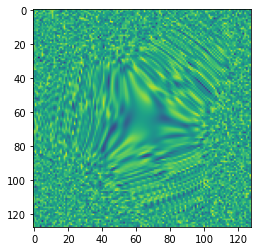

In [46]:
# test with arbitrary input x
x = np.array([0.1,0.1])
# x = np.array([ 0.2768, 0.5056])
ronch, output = get_GPT_output(x, model, 0)
print(output)
plt.imshow(ronch)

In [47]:
# Function that generate n random data point with noise.

# input:
# n: number of datapoints to gerate
def generate_initial_data(n, model, aperture):
    # generate training data
    train_x = torch.rand(n, 2, device=device, dtype=dtype)
    output_y = [get_GPT_output(np.array(train_x[i,:]), model, aperture)[1] for i in range(n)]
    train_y = torch.tensor(output_y).unsqueeze(-1)
    train_y = train_y + NOISE_SE * torch.randn_like(train_y) if NOISE_SE else train_y
    best_observed_value = train_x.max().item()
    return train_x, train_y

In [49]:
# initial optimization without applying aperture
best_seen_rep = []
best_par_rep = []
best_ronchigram_rep = []
best_seen_ronchigram = np.zeros([128, 128])

if option_standardize:
    outcome_transformer = Standardize( m = 1,
    batch_shape = torch.Size([]),
    min_stdv = 1e-08)

for irep in range(nrep):
    
    train_X, train_Y = generate_initial_data(n = 10, model = model, aperture = 0)
    
    if option_standardize:
        gp = SingleTaskGP(train_X, train_Y, outcome_transform = outcome_transformer)
    else:
        gp = SingleTaskGP(train_X, train_Y)
        
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)
    bounds = torch.stack([torch.zeros(2, device = device), torch.ones(2, device = device)])
    best_observed_value = []
    
    for iteration in range(niter):
        print(str(iteration) + '/' + str(niter))

        fit_gpytorch_model(mll)

        UCB = UpperConfidenceBound(gp, beta = 2)    
        candidate, acq_value = optimize_acqf(
            UCB, bounds=bounds, q = 1, num_restarts=5, raw_samples=20,
        )
        new_x = candidate.detach()
        print(new_x)
        
        result = get_GPT_output(np.array(new_x[0]), model, 0)
        new_y = torch.tensor(result[1]).unsqueeze(-1).unsqueeze(-1)
        new_y = new_y + NOISE_SE * torch.randn_like(new_y)
        train_X = torch.cat([train_X, new_x])
        train_Y = torch.cat([train_Y, new_y])
        if not best_observed_value:
            best_par = np.array(new_x[0])
            best_value = np.array(new_y[0][0])
            best_seen_ronchigram = result[0]
        elif result[1] > best_value:
            best_par = np.array(new_x[0])
            best_value = result[1]
            best_seen_ronchigram = result[0]
        best_observed_value.append(best_value)

        # update GP model using dataset with new datapoint
        if option_standardize:
            gp = SingleTaskGP(train_X, train_Y, outcome_transform = outcome_transformer)
        else:
            gp = SingleTaskGP(train_X, train_Y)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

        print(iteration, best_value)
        
    best_seen_rep.append(np.array(best_observed_value))
    best_par_rep.append(best_par)
    best_ronchigram_rep.append(best_seen_ronchigram)
    
np.save('Initial_optimization_2D_std_50iter_1reps_x.npy', np.array(train_X))
np.save('Initial_optimization_2D_std_50iter_1reps_y.npy', np.array(train_Y))

0/50
tensor([[0.3753, 0.6812]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 0.9391592144966125
1/50
tensor([[0.4530, 0.4216]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1 0.9434677921235561
2/50
tensor([[0.3260, 0.5201]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2 0.9434677921235561
3/50
tensor([[0.2247, 1.0000]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3 0.9434677921235561
4/50
tensor([[0.3594, 0.4071]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4 0.9643771573901176
5/50
tensor([[0.3627, 0.3671]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


5 0.9643771573901176
6/50
tensor([[0.3689, 0.4599]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


6 0.9706748500466347
7/50
tensor([[0.3764, 0.4800]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


7 0.9706748500466347
8/50
tensor([[0.3802, 0.4794]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


8 0.9706748500466347
9/50
tensor([[0.3805, 0.4717]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


9 0.9706748500466347
10/50
tensor([[0.3644, 0.4388]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


10 0.9706748500466347
11/50
tensor([[0.3630, 0.4301]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


11 0.9759561270475388
12/50
tensor([[0.3576, 0.4175]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


12 0.9761674106121063
13/50
tensor([[0.3555, 0.3989]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


13 0.9761674106121063
14/50
tensor([[0.3560, 0.3976]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


14 0.9761674106121063
15/50
tensor([[0.3569, 0.4052]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


15 0.9761674106121063
16/50
tensor([[0.2131, 0.7439]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


16 0.9761674106121063
17/50
tensor([[0.3513, 0.4331]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


17 0.9761674106121063
18/50
tensor([[0.3584, 0.4303]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


18 0.9761674106121063
19/50
tensor([[0.3571, 0.4312]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


19 0.9761674106121063
20/50
tensor([[0.3544, 0.4322]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


20 0.9761674106121063
21/50
tensor([[0.3545, 0.4324]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


21 0.9761674106121063
22/50
tensor([[0.3926, 0.8059]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


22 0.9761674106121063
23/50
tensor([[0.3568, 0.4315]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


23 0.9761674106121063
24/50
tensor([[0.2752, 0.6699]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


24 0.9761674106121063
25/50
tensor([[0.3663, 0.4299]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


25 0.9761674106121063
26/50
tensor([[0.3670, 0.4298]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


26 0.9761674106121063
27/50
tensor([[0.3544, 0.4328]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


27 0.9761674106121063
28/50
tensor([[0.3668, 0.4296]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


28 0.9761674106121063
29/50
tensor([[0.3508, 0.4332]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


29 0.9761674106121063
30/50
tensor([[0.3692, 0.4284]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


30 0.9761674106121063
31/50
tensor([[0.3481, 0.4321]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


31 0.9761674106121063
32/50
tensor([[0.3712, 0.4264]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


32 0.9761674106121063
33/50
tensor([[0.3704, 0.4267]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


33 0.9761674106121063
34/50
tensor([[0.3632, 0.4280]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


34 0.9761674106121063
35/50
tensor([[0.3657, 0.4277]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


35 0.9761674106121063
36/50
tensor([[0.3667, 0.4276]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


36 0.9761674106121063
37/50
tensor([[0.3648, 0.4280]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


37 0.9761674106121063
38/50
tensor([[0.2093, 0.3823]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


38 0.9761674106121063
39/50
tensor([[0.3579, 0.4295]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


39 0.9761674106121063
40/50
tensor([[0.3555, 0.4300]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


40 0.9761674106121063
41/50
tensor([[0.3538, 0.4306]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


41 0.9761674106121063
42/50
tensor([[0.5115, 0.6003]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


42 0.9761674106121063
43/50
tensor([[0.3482, 0.4286]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


43 0.9761674106121063
44/50
tensor([[0.3635, 0.4274]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


44 0.9761674106121063
45/50
tensor([[0.3649, 0.4272]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


45 0.9761674106121063
46/50
tensor([[0.3663, 0.4272]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


46 0.9761674106121063
47/50
tensor([[0.3668, 0.4271]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


47 0.9761674106121063
48/50
tensor([[0.3662, 0.4272]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


48 0.9761674106121063
49/50
tensor([[0.3678, 0.4271]])


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


49 0.9761674106121063


In [50]:
train_Y

tensor([[0.8773],
        [0.9512],
        [0.7964],
        [0.8211],
        [0.5511],
        [0.8780],
        [0.9154],
        [0.7617],
        [0.6108],
        [0.8839],
        [0.9392],
        [0.9435],
        [0.9427],
        [0.8071],
        [0.9644],
        [0.9537],
        [0.9707],
        [0.9638],
        [0.9597],
        [0.9564],
        [0.9696],
        [0.9760],
        [0.9762],
        [0.9676],
        [0.9662],
        [0.9707],
        [0.9297],
        [0.9674],
        [0.9749],
        [0.9760],
        [0.9736],
        [0.9727],
        [0.9029],
        [0.9757],
        [0.9643],
        [0.9748],
        [0.9711],
        [0.9721],
        [0.9695],
        [0.9668],
        [0.9630],
        [0.9584],
        [0.9679],
        [0.9671],
        [0.9733],
        [0.9728],
        [0.9706],
        [0.9731],
        [0.9171],
        [0.9756],
        [0.9756],
        [0.9755],
        [0.9234],
        [0.9636],
        [0.9738],
        [0

## Plot results

In [7]:
temp = np.load('Refine_optimization_50iter_50reps_value.npy')
len(temp)

29

In [7]:
result = np.load(result_path + 'RandomStartx30_50iter_initialrun_emit+defocus_prmean=0_rltBoundary_2-None.npy')
result.shape

(30, 51, 8)

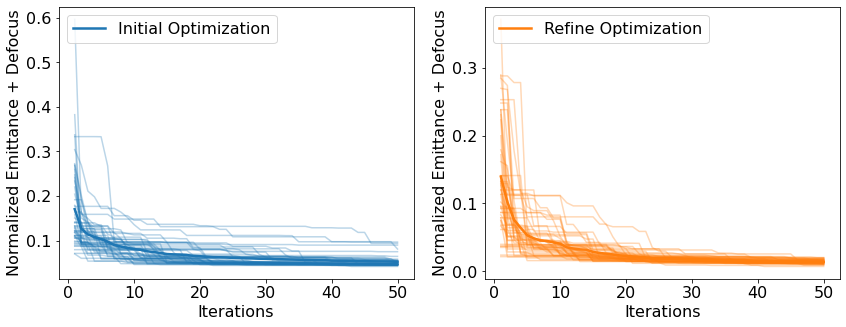

In [4]:
fig, ax = plt.subplots(1, 2, figsize = [14, 5])
result_path = '/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/'

result = np.load('Initial_optimization_50iter_50reps_value.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
niter = result.shape[1]
ax[0].plot(np.linspace(1, 50, 50), 1 - avg, linewidth = 2.5, label = 'Initial Optimization')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax[0].plot(np.linspace(1, 50, 50), 1 - result[i,:niter], c='C0', alpha = 0.3)
ax[0].legend(loc='upper left', ncol=1, fontsize = 16)
ax[0].set_xlabel('Iterations',fontsize = 16)
ax[0].set_ylabel('Normalized Emittance + Defocus', fontsize = 16)
ax[0].tick_params(axis='x', labelsize=16)
ax[0].tick_params(axis='y', labelsize=16)

result = np.load('Refine_optimization_50iter_50reps_value.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
niter = result.shape[1]
ax[1].plot(np.linspace(1, 50, 50), 1 - avg, linewidth = 2.5, c = 'C1', label = 'Refine Optimization')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax[1].plot(np.linspace(1, 50, 50), 1 - result[i,:niter], c='C1', alpha = 0.3)
ax[1].legend(loc='upper left', ncol=1, fontsize = 16)
ax[1].set_xlabel('Iterations',fontsize = 16)
ax[1].set_ylabel('Normalized Emittance + Defocus', fontsize = 16)
ax[1].tick_params(axis='x', labelsize=16)
ax[1].tick_params(axis='y', labelsize=16)

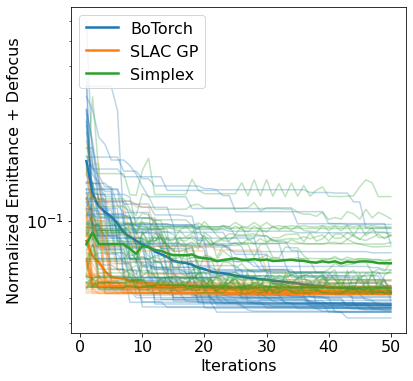

In [41]:
fig, ax = plt.subplots( figsize = [6, 6])
result_path = '/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/'

result = np.load('Initial_optimization_50iter_50reps_value.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
niter = result.shape[1]
ax.plot(np.linspace(1, 50, 50), 1 - avg, linewidth = 2.5, label = 'BoTorch')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(np.linspace(1, 50, 50), 1 - result[i,:niter], c='C0', alpha = 0.3)
ax.legend(loc='upper left', ncol=1, fontsize = 16)
ax.set_xlabel('Iterations',fontsize = 16)
ax.set_ylabel('Normalized Emittance + Defocus', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

result = np.load(result_path + 'RandomStartx30_50iter_initialrun_emit+defocus_prmean=0_rltBoundary_2-None.npy')
result = result[:,:50,0]
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
niter = result.shape[1]
ax.plot(np.linspace(1, 50, 50), 1 - avg, linewidth = 2.5, label = 'SLAC GP')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(np.linspace(1, 50, 50), 1 - result[i,:niter], c='C1', alpha = 0.3)
ax.legend(loc='upper left', ncol=1, fontsize = 16)
ax.set_xlabel('Iterations',fontsize = 16)
ax.set_ylabel('Normalized Emittance + Defocus', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

result = np.load(result_path + 'Simplex_Y-obs-fullGPT_30rep.npy', allow_pickle = True)
result = [np.array(entry)[0:50,0] for entry in result]
result = np.array(result)
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
niter = result.shape[1]
ax.plot(np.linspace(1, 50, 50), 1 - avg, linewidth = 2.5, c = 'C2', label = 'Simplex')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(np.linspace(1, 50, 50), 1 - result[i,:niter], c='C2', alpha = 0.3)
ax.legend(loc='upper left', ncol=1, fontsize = 16)
ax.set_xlabel('Iterations',fontsize = 16)
ax.set_ylabel('Normalized Emittance + Defocus', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.set_yscale('log')

In [38]:
result = np.load(result_path + 'Simplex_Y-obs-fullGPT_30rep.npy', allow_pickle = True)
result = [np.array(entry)[0:50,0] for entry in result]
result = np.array(result)

In [37]:
np.array(result).shape

(30, 30)